# Project4 - Group11

## Algorithm implementation and evaluation 

### Load Data and data preprocessing 

In [119]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import timeit
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns

In [120]:
data = pd.read_csv('../data/ml-latest-small/ratings.csv')

In [121]:
#train, test = train_test_split(data, test_size = 0.2)

#train_user = list(train["userId"])
#train_movie = list(train["movieId"])
#train_rate = list(train["rating"])

#test_user = list(test["userId"])
#test_movie = list(test["movieId"])
#test_rate = list(test["rating"])

### Algorithm implementation with regularization 

#### Basic model
#### A1+R1+R2

In [122]:
def sgd_bias(data, train, f = 10, lam = 0.3, lrate = 0.01, epoch = 10, stopping_deriv = 0.01):

    #define the length of unique userid and movieid 
    U = len(data['userId'].unique())
    I = len(data['movieId'].unique())
    
    p = np.random.randn(f, U)
    q = np.random.randn(f, I)
    
    tmp1 = [i for i in range(I)]
    tmp2 = data['movieId'].unique()
    movie_dic = dict(zip(tmp2,tmp1))
    
    
    train_data = np.array(train)
    
    user_mean = data.groupby('userId').mean()['rating']
    user_mean = np.array(user_mean)
    
    item_mean = data.groupby('movieId').mean()['rating']
    tmp_item_index = item_mean.index.tolist()
    tmp_movie_dic = dict(zip(tmp_item_index, [i for i in range(I)]))
    item_mean = np.array(item_mean)
    
    
    
    total_mean = np.mean(data['rating'])
    user_bias = user_mean - total_mean
    item_bias = item_mean - total_mean
    
    sample_index = [index for index in range(train_data.shape[0])]
    
    
    
    
    for e in range(epoch):
        random.shuffle(sample_index)
        for index in sample_index:
            u = int(train_data[index,0])
            i = int(train_data[index,1])
            r_ui = train_data[index,2]
            bias_u = user_bias[u-1]
            bias_i = item_bias[tmp_movie_dic[i]]
            e_ui = r_ui - total_mean - bias_u - bias_i - np.dot(q[:,movie_dic[i]].T, p[:,u-1])
            
            grad_user = e_ui * p[:,u-1] - lam * q[:, movie_dic[i]]
            if(all(np.abs(grad)) > stopping_deriv for grad in grad_user):
                q[:,movie_dic[i]] = q[:,movie_dic[i]] + lrate * grad_user
                
            grad_item = e_ui * q[:,movie_dic[i]] - lam* p[:,u-1]
            if(all(np.abs(grad)) > stopping_deriv for grad in grad_item):
                p[:,u-1] = p[:,u-1] + lrate * grad_item
                
            grad_user_bias = e_ui - lam * bias_u
            if (np.abs(grad_user_bias) > stopping_deriv):
                user_bias[u-1] = bias_u + lrate * grad_user_bias
            
            grad_item_bias = e_ui - lam * bias_i
            if (np.abs(grad_item_bias) > stopping_deriv):
                item_bias[tmp_movie_dic[i]] = bias_i + lrate * grad_item_bias 
        
        
        
    r_ij = total_mean + user_bias + np.dot(q.T,p)
    r_ij = (r_ij.T + item_bias).T
    return p,q, r_ij

In [123]:
start1 = timeit.default_timer()
p,q,r_ij = sgd_bias(data, train)
stop1 = timeit.default_timer()
           
print('Running Time for SGD+R1+R2: ', stop1 - start1, 's')

Running Time for SGD+R1+R2:  28.774070723999102 s


### Cross-Validation for parameter tuning

In [124]:
# function of computing RMSE
def RMSE(rating, est_rating):
    sqr_error = []
    for r in range(rating.shape[0]):
        u = int(rating[r,0])
        i = int(rating[r,1])
        r_ui = rating[r,2]
        est_r_ui = est_rating.at[i, u]
        sqr_error.append((r_ui - est_r_ui) ** 2)
    return np.sqrt(np.mean(sqr_error))      

In [7]:
#est_rating = r_ij
#est_rating = pd.DataFrame(est_rating)

In [18]:
#est_rating.index = data['movieId'].unique().tolist()
#est_rating.columns = data['userId'].unique().tolist()
#est_rating = pd.DataFrame(est_rating)
#train_data = np.array(train)
#mse = RMSE(train_data, est_rating)

In [125]:
def get_fold(data,K):
    fold_num = []
    i =0
    while i<len(data):
        for j in range(5):
            if(i<len(data)):
                fold_num.append(j)
            i+=1
    return fold_num

In [126]:
# function of conducting cross-validation
def cv(tr, K, f, lambda_):
    df = tr
    df['fold'] = get_fold(tr,K)
    test_errors = []
    train_errors = []
    for k in range(K):
#        print("fold: ", k)
        k_test = df[df.fold == k]
        k_train = df[df.fold != k]
        
        train_error, test_error=predict(k_train,k_test,f,lambda_)
        train_errors.append(train_error)
        test_errors.append(test_error)
    return train_errors, test_errors

In [127]:
# function of computing training RMSE and test RMSE  
    def predict(train_data, test_data,f,lambda_):
        
        train_RMSE = []
        test_RMSE = []
        p,q,r_ij = sgd_bias(data, train_data,f,lambda_)
        est_rating = pd.DataFrame(r_ij)
        est_rating.index = data['movieId'].unique().tolist()
        est_rating.columns = data['userId'].unique().tolist()
        est_rating = pd.DataFrame(est_rating)
        train_data = np.array(train_data)
        test_data = np.array(test_data)

        train_RMSE_cur = RMSE(train_data, est_rating)
        train_RMSE.append(train_RMSE_cur)
#        print("training RMSE:", train_RMSE_cur)
        test_RMSE_cur = RMSE(test_data, est_rating)
        test_RMSE.append(test_RMSE_cur)
#        print("test RMSE:", test_RMSE_cur)

        return [train_RMSE, test_RMSE]

In [138]:
# Parameter tuning of f and lambda
f_s = np.array([1,2,5,10]).astype(int)
lambda_s= np.array([0.01,0.1,0.5,1]).astype(int)

#train for 10 iterarions each time
trains = []
tests = []
for f in f_s:
    train_avs = []
    test_avs = []
    for lambda_ in lambda_s:
        tr_rmse,tst_rmse=cv(data, 5, f, lambda_)
        
        train_avs.append(np.mean(tr_rmse))
        test_avs.append(np.mean(tst_rmse))
    trains.append(train_avs)
    tests.append(test_avs)
print(trains)
print(tests)

[[1.2306412472151531, 1.2309874703281547, 1.2309568201410392, 1.150403979511212], [1.2294976511088251, 1.2296482700809186, 1.2297834897063686, 1.149326762744379], [1.2250079600835453, 1.2249080844468923, 1.2238998893872333, 1.1487575647461192], [1.215637822724545, 1.217785806774155, 1.2162406035528233, 1.1474340465136523]]
[[1.240774352466594, 1.240994141225063, 1.2411173997174143, 1.1529121618923028], [1.2462022477161743, 1.2476701859454233, 1.2476501610771296, 1.152321993438281], [1.2711646572167399, 1.269918336273435, 1.2696652274398894, 1.1526899552145986], [1.3288668879266463, 1.3288496003602943, 1.3287919635364593, 1.1528456632405326]]


In [148]:
#save the output
#trains_basic=pd.DataFrame(trains)
#trains_test=pd.DataFrame(tests)
#trains_basic.to_csv("../output/trains.csv")
#trains_test.to_csv("../output/tests.csv")

#### Plot RMSE for basic model

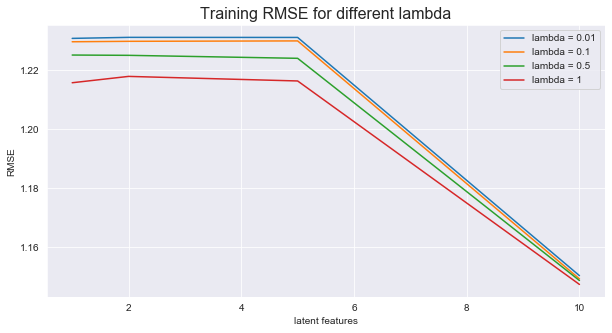

In [164]:
plt.figure(figsize=(10,5))
plt.plot(f_s,trains[0])
plt.plot(f_s,trains[1])
plt.plot(f_s,trains[2])
plt.plot(f_s,trains[3])

plt.legend(['lambda = 0.01', 'lambda = 0.1', 'lambda = 0.5',
           'lambda = 1'], loc='upper right')
plt.xlabel('latent features', fontsize=10)
plt.ylabel('RMSE', fontsize=10)
plt.title("Training RMSE for different lambda", fontsize=16)

plt.show()

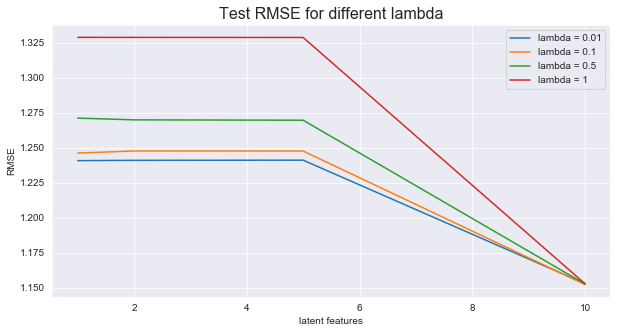

In [142]:

plt.figure(figsize=(10,5))
plt.plot(f_s,tests[0])
plt.plot(f_s,tests[1])
plt.plot(f_s,tests[2])
plt.plot(f_s,tests[3])
plt.legend(['lambda = 0.01', 'lambda = 0.1', 'lambda = 0.5', 'lambda = 1'], loc='upper right')
plt.xlabel('latent features', fontsize=10)
plt.ylabel('RMSE', fontsize=10)
plt.title("Test RMSE for different lambda", fontsize=16)

plt.show()

#### We choose lambda=0.1 f=10

## Postprocessing - KNN 

### Optimization model
### A1+R1+R2+P2

In [104]:
def knn(p,q,r_ij, k=1,test_point=None):
    U = len(test_point['userId'].unique())
    I = len(test_point['movieId'].unique())
    
    sim = pairwise_distances(q.T,metric='cosine')
    sim = pd.DataFrame(sim)
    knn_r_ij = []
    tmp = list(test_point['movieId'].unique())
    
    tmp1 = [i for i in range(I)]
    tmp2 = test_point['movieId'].unique()
    movie_dic = dict(zip(tmp2,tmp1))
    
    for i in tmp:
        k_neighbors_class = np.argsort(sim[movie_dic[i]])[1:1+k]
        knn_r_ij.append(np.mean(r_ij[k_neighbors_class,:],axis=0))
    knn_r_ij = pd.DataFrame(knn_r_ij)
    knn_r_ij.index = test_point['movieId'].unique().tolist()
    knn_r_ij.columns = test_point['userId'].unique().tolist()
    
    return knn_r_ij

In [33]:
#est_rating = pd.DataFrame(knn_r_ij)
#est_rating.index = data['movieId'].unique().tolist()
#est_rating.columns = data['userId'].unique().tolist()
#est_rating = pd.DataFrame(est_rating)
#train_data = np.array(train)
#mse = RMSE(train_data, est_rating)

### Cross-Validation for parameter tuning

In [135]:
p_1,q_1,r_ij_1 = sgd_bias(data, train, 10,0.1)

In [111]:
  def predict_knn(train_data, test_data,kk):

       
        train_RMSE = []
        test_RMSE = []
        knn_r_ij = knn(p_1,q_1,r_ij_1,kk,test_point = data)
        est_rating = pd.DataFrame(knn_r_ij)
        est_rating.index = data['movieId'].unique().tolist()
        est_rating.columns = data['userId'].unique().tolist()
        est_rating = pd.DataFrame(est_rating)
        train_data = np.array(train_data)
        test_data = np.array(test_data)


        train_RMSE_cur = RMSE(train_data, est_rating)
        train_RMSE.append(train_RMSE_cur)
#        print("training RMSE:", train_RMSE_cur)
        test_RMSE_cur = RMSE(test_data, est_rating)
        test_RMSE.append(test_RMSE_cur)
#        print("test RMSE:", test_RMSE_cur)

        return [train_RMSE, test_RMSE]

In [133]:
def cv_knn(tr, K, KK):
    df = tr
    df['fold'] = get_fold(tr,K)
    test_errors = []
    train_errors = []
    for k in range(K):
#        print("fold: ", k)
        k_test = df[df.fold == k]
        k_train = df[df.fold != k]
        
        train_error, test_error=predict_knn(k_train,k_test,KK)
        train_errors.append(train_error)
        test_errors.append(test_error)
    return train_errors, test_errors

In [137]:
#train for 10 iterarions each time
trains_knn = []
tests_knn = []
for KK in range(1,5):
        train_knn,test_knn = cv_knn(data,5,KK)
        trains_knn.append(np.mean(train_knn))
        tests_knn.append(np.mean(test_knn))

print(trains_knn)
print(tests_knn)

[1.3391947595433813, 1.1728569810853993, 1.1213647232076458, 1.0911644617030838] [1.3391771314001972, 1.1728395397433458, 1.1213478585122283, 1.0911407624831038]


### Plot RMSE for optimization model 

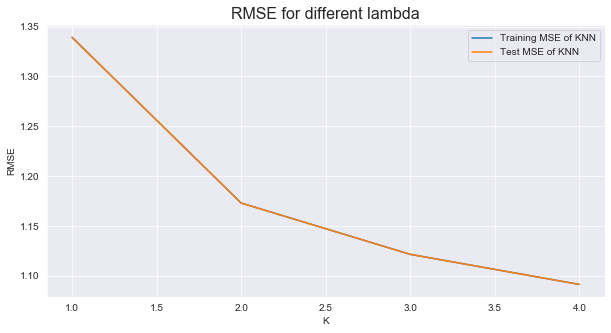

In [165]:
plt.figure(figsize=(10,5))
plt.plot(range(1,5),trains_knn)
plt.plot(range(1,5),tests_knn)
plt.legend(["Training MSE of KNN","Test MSE of KNN"], loc='upper right')
plt.xlabel('K', fontsize=10)
plt.ylabel('RMSE', fontsize=10)
plt.title("RMSE for different lambda", fontsize=16)
plt.show()

#### We choose k=4 
#### According to the results above, we choose f=10, lambda=0.1, k=4

## Postprocessing - Kernel Ridge Regression 

### Optimization model
### A1+R1+R2+P3

In [ ]:
def krr(q,data,train):
    import numpy as np
    import pandas as pd
    
    from sklearn import preprocessing
    from sklearn.kernel_ridge import KernelRidge  
    
        
    n_movies=np.unique(data.movieId).shape[0]
    n_users=np.unique(data.userId).shape[0]

    updated_rating_mat=np.zeros((n_users,n_movies))
    
    q=q.T
    
    #normalize q matrix
    q_normalize=preprocessing.normalize(q) #mat_q:
    q_normalize.shape
    q_normalize=pd.DataFrame(q_normalize.T)
    q_normalize.columns=[np.unique(data.movieId)]
    
       
    for i in range(n_users):
        
        rating_i=train.loc[train['userId']==i+1,['movieId','rating']]
        movieId_i=rating_i.iloc[:,0]
        y_i=rating_i.iloc[:,1]#rating vector of user i
           
        #create X for user i
        X_i=q_normalize.loc[:,movieId_i]
        
        #predictions of krr
        krr = KernelRidge(alpha=0.5,kernel="rbf")
        krr.fit(X_i.T,y_i)

        pred_krr=krr.predict(q_normalize.T)            
        updated_rating_mat[i]=pred_krr          
        
    return(updated_rating_mat)


In [ ]:
krr_r_ij = krr(q,data,train)
est_rating1 = pd.DataFrame(krr_r_ij)
est_rating1.columns = data['movieId'].unique().tolist()
est_rating1.index = data['userId'].unique().tolist()
est_rating1 = pd.DataFrame(est_rating1)
est_rating1 = est_rating1.transpose()
train_data = np.array(train)
mse1 = RMSE(train_data, est_rating1)
mse1